In [1]:
from google.colab import files
import io
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.gridspec as gridspec

In [2]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1) Empirical divergence correlations and their 95% confidence interval

In [3]:
# Function to compute the confidence interval on spearman rho
def spearman_ci(x, y, ci=95, n_boots=10000, seed=22):
  x = np.asarray(x)
  y = np.asarray(y)

  # (n_boots, n_observations) paired arrays
  rng = np.random.default_rng(seed) # For reproducible bootstrapping
  rand_ixs = rng.integers(0, x.shape[0], size=(n_boots, x.shape[0]))
  x_boots = x[rand_ixs]
  y_boots = y[rand_ixs]

  # Spearman correlations
  corrs = []

  for row in range(x_boots.shape[0]):
    rho = stats.spearmanr(x_boots[row, :], y_boots[row, :])
    corrs.append(rho[0])

  # Quantiles of correlations coefficients and confidence interval
  corrs = np.asarray(corrs)

  ci_low = np.percentile(corrs, (100 - ci) / 2)
  ci_high = np.percentile(corrs, (ci + 100) / 2)

  return ci_low, ci_high, corrs

First for the correlation between the magnitudes of transcriptional and translational divergence

In [4]:
# Empirical divergence data is imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                                 'Final_figures/Data_sim_ready/'
                                 'couples_divergence.csv')

# Only WGD-derived pairs are kept
couples_divergence = couples_divergence[couples_divergence['Duplication'] == 'WGD'].reset_index(drop=True)

In [5]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['bm_fold_original'],
                      couples_divergence['bp_fold_original'])
spearman_ci_div = (rho_emp[0], rho_emp[1])
dist_boot_div = rho_emp[2]

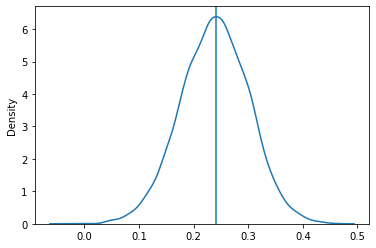

In [6]:
# Quick validation that bootstrapping is valid:
center_div = stats.spearmanr(couples_divergence['bm_fold_original'],
                         couples_divergence['bp_fold_original'])[0]

sns.kdeplot(dist_boot_div)
plt.axvline(x=center_div)

The 95% confidence interval is also computed for the signed divergence correlation:

In this case, a duplicated dataset is used, so that logfold changes are computed in the two possible orientations for each paralog pair

In [7]:
couples_divergence['bm_fold_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['bp_fold_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['bm_fold_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['bp_fold_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))

In [8]:
logfold_dupli_1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_1', 'bp_fold_signed_1']].copy()

logfold_dupli_1.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']


logfold_dupli_2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_2', 'bp_fold_signed_2']].copy()

logfold_dupli_2.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']

logfold_dupli = pd.concat([logfold_dupli_1, logfold_dupli_2])

In [9]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(logfold_dupli['bm_fold_signed'],
                      logfold_dupli['bp_fold_signed'])
spearman_ci_sign = (rho_emp[0], rho_emp[1])
dist_boot_sign = rho_emp[2]

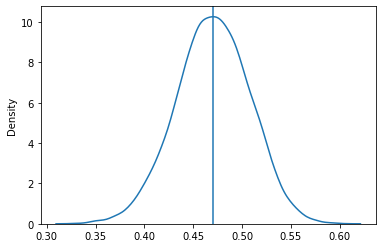

In [10]:
# Quick validation that bootstrapping is valid:
center_sign = stats.spearmanr(logfold_dupli['bm_fold_signed'],
                              logfold_dupli['bp_fold_signed'])[0]

sns.kdeplot(dist_boot_sign)
plt.axvline(x=center_sign)

Finally, the same is done for the correlation between the divergence ratio and the magnitude of protein abundance divergence:

In [11]:
couples_divergence['div_ratio'] = couples_divergence['bm_fold_original'] - couples_divergence['bp_fold_original']

In [12]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['pEst_fold_original'],
                      couples_divergence['div_ratio'])
spearman_ci_ratio = (rho_emp[0], rho_emp[1])
dist_boot_ratio = rho_emp[2]

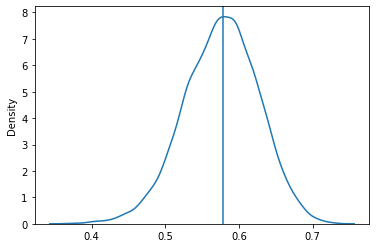

In [13]:
# Quick validation that bootstrapping is valid:
center_ratio = stats.spearmanr(couples_divergence['pEst_fold_original'],
                         couples_divergence['div_ratio'])[0]

sns.kdeplot(dist_boot_ratio)
plt.axvline(x=center_ratio)

## 2) Importing simulated correlations for a range of duplication effects

In [14]:
corr_dupli = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                         'Final_figures/Dupli_effect/'
                         'Corr_dupli.csv')

corr_sign = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                        'Final_figures/Dupli_effect/'
                        'Corr_sign_dupli.csv')

corr_ratio = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                         'Final_figures/Dupli_effect/'
                         'Corr_ratio_dupli.csv')

In [15]:
# 'Run' identifiers are replaced by mutational target size ratios
ratios_ids = {'Bm1': '1', 'Bm3': '3', 'Bm4': '4', 'Bm8': '8'}

for row in range(corr_dupli.shape[0]):
  corr_dupli.at[row, 'Run'] = ratios_ids[corr_dupli.at[row, 'Run']]

for row in range(corr_sign.shape[0]):
  corr_sign.at[row, 'Run'] = ratios_ids[corr_sign.at[row, 'Run']]

for row in range(corr_ratio.shape[0]):
  corr_ratio.at[row, 'Run'] = ratios_ids[corr_ratio.at[row, 'Run']]

In [16]:
# Splitting data according to the model
corr_dupli_min = corr_dupli[corr_dupli['Model'] == 'Minimal']
corr_dupli_mixed = corr_dupli[corr_dupli['Model'] == 'Mixed']

corr_sign_min = corr_sign[corr_sign['Model'] == 'Minimal']
corr_sign_mixed = corr_sign[corr_sign['Model'] == 'Mixed']

corr_ratio_min = corr_ratio[corr_ratio['Model'] == 'Minimal']
corr_ratio_mixed = corr_ratio[corr_ratio['Model'] == 'Mixed']

## 3) Construction of the figure

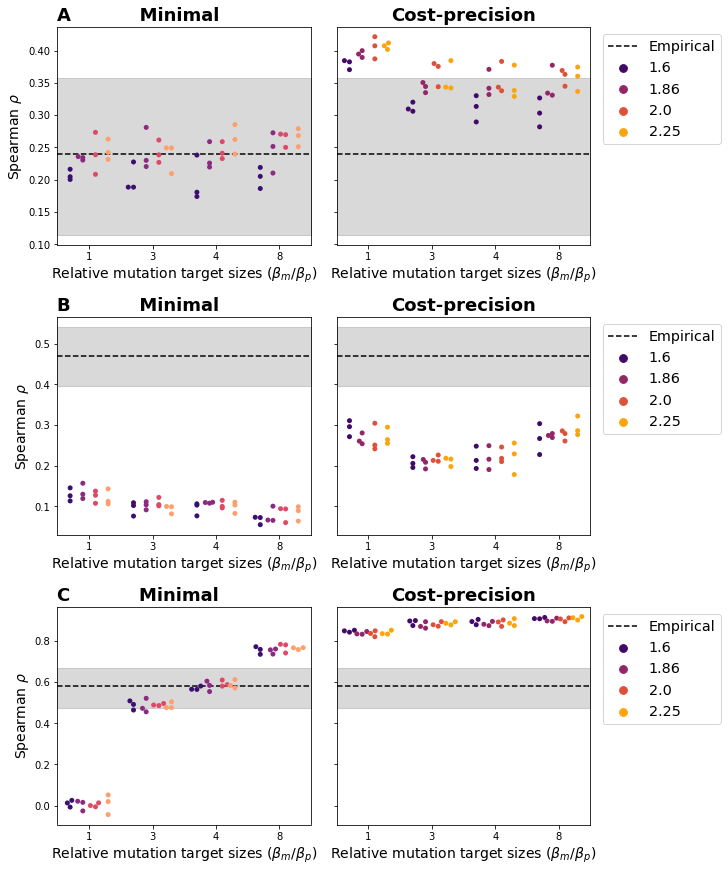

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12), constrained_layout=True,
                        sharey='row')

# First, divergence correlations
sns.swarmplot(x='Run', y='spearman', hue='Dupli_effect', data=corr_dupli_min,
              ax=axs[0,0], palette='magma', dodge=True)

sns.swarmplot(x='Run', y='spearman', hue='Dupli_effect', data=corr_dupli_mixed,
              ax=axs[0,1], palette='inferno', dodge=True)

for ax in [axs[0,0], axs[0,1]]:
  x_lims = ax.get_xlim()
  ax.axhline(y=center_div, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_div[0], spearman_ci_div[1], 
                  color='black', alpha=0.15)
axs[0,0].legend([],[], frameon=False)
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                 fontsize='x-large')

# Second signed divergence correlations
sns.swarmplot(x='Run', y='spearman', hue='Dupli_effect', data=corr_sign_min,
              ax=axs[1,0], palette='magma', dodge=True)

sns.swarmplot(x='Run', y='spearman', hue='Dupli_effect', data=corr_sign_mixed,
              ax=axs[1,1], palette='inferno', dodge=True)

for ax in [axs[1,0], axs[1,1]]:
  x_lims = ax.get_xlim()
  ax.axhline(y=center_sign, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_sign[0], spearman_ci_sign[1], 
                  color='black', alpha=0.15)

axs[1,0].legend([],[], frameon=False)
axs[1, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                 fontsize='x-large')

# Third for the correlations with the divergence ratio
sns.swarmplot(x='Run', y='spearman', hue='Dupli_effect', data=corr_ratio_min,
              ax=axs[2,0], palette='magma', dodge=True)

sns.swarmplot(x='Run', y='spearman', hue='Dupli_effect', data=corr_ratio_mixed,
              ax=axs[2,1], palette='inferno', dodge=True)

for ax in [axs[2,0], axs[2,1]]:
  x_lims = ax.get_xlim()
  ax.axhline(y=center_ratio, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_ratio[0], spearman_ci_ratio[1], 
                  color='black', alpha=0.15)

axs[2,0].legend([],[], frameon=False)
axs[2, 1].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                 fontsize='x-large')

# Axes labels
for ax in [axs[0,0], axs[1,0], axs[2,0]]:
  ax.set_ylabel(r"Spearman $\rho$", fontsize=14)

for ax in [axs[0,1], axs[1,1], axs[2,1]]:
  ax.set_ylabel('')

for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1]]:
  ax.set_xlabel(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
                fontsize=14)
  
# Titles
axs[0,0].set_title('A           Minimal', loc='left', fontsize=18, fontweight="bold")
axs[1,0].set_title('B           Minimal', loc='left', fontsize=18, fontweight="bold")
axs[2,0].set_title('C           Minimal', loc='left', fontsize=18, fontweight="bold")

axs[0,1].set_title('Cost-precision', loc='center', fontsize=18, fontweight="bold")
axs[1,1].set_title('Cost-precision', loc='center', fontsize=18, fontweight="bold")
axs[2,1].set_title('Cost-precision', loc='center', fontsize=18, fontweight="bold")

# Saving the figure
FigS6 = plt.gcf()
FigS6.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/'
'SuppFig6_final.png', bbox_inches='tight')
FigS6.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/'
'SuppFig6_final.pdf', bbox_inches='tight')